In [2]:
import kagglehub

path = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [3]:
import os
data_path='/kaggle/input/flickr8k'
working='/kaggle/working'
os.listdir(data_path)

['captions.txt', 'Images']

In [4]:
print(os.listdir(f"{data_path}/Images")[:10])

['3226254560_2f8ac147ea.jpg', '214543992_ce6c0d9f9b.jpg', '2366643786_9c9a830db8.jpg', '3368819708_0bfa0808f8.jpg', '2190227737_6e0bde2623.jpg', '2752809449_632cd991b3.jpg', '3097776588_312932e438.jpg', '1206506157_c7956accd5.jpg', '1319634306_816f21677f.jpg', '2465218087_fca77998c6.jpg']


In [6]:
import numpy as np
import string
import os
import pickle
from tqdm import tqdm
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [8]:
model_res=ResNet50(weights='imagenet')
for layer in model_res.layers:
    layer.trainable = False
model_res=Model(inputs=model_res.inputs,outputs=model_res.layers[-2].output)
print(model_res.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [9]:
import pickle
with open('/kaggle/input/image-cap/keras/default/1/features.pkl', 'rb') as f:
    features = pickle.load(f)


In [11]:
features_file = '/kaggle/input/image-cap/keras/default/1/features.pkl'

if os.path.exists(features_file):
    with open(features_file, 'rb') as f:
        features = pickle.load(f)
    print("Loaded features")
else:
    features = {}
    dir = os.path.join(data_path, 'Images')
    
    for img in tqdm(os.listdir(dir)):
        img_path = dir + '/' + img
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model_res.predict(image, verbose=0)

        image_id = img.split(".")[0]
        features[image_id] = feature

    with open(features_file, 'wb') as f:
        pickle.dump(features, f)
    print("Features saved")

Loaded features


In [ ]:
pickle.dump(features,open(os.path.join(working,'features.pkl'),'wb'))

In [12]:
with open(os.path.join(data_path,'captions.txt'),'r')as txt:
    next(txt)
    captions=txt.read()

In [13]:
len(captions)

3319280

In [14]:
mapping={}
for line in tqdm(captions.split('\n')):
    tokens=line.split(',')
    if len(line)<2:
        continue
    else:
        image_id,caption = tokens[0],tokens[1]
        image_id=image_id.split('.')[0]
        caption="".join(caption)
        if image_id not in mapping:
            mapping[image_id]=[]
        mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 430590.02it/s]


In [15]:
len(mapping)

8091

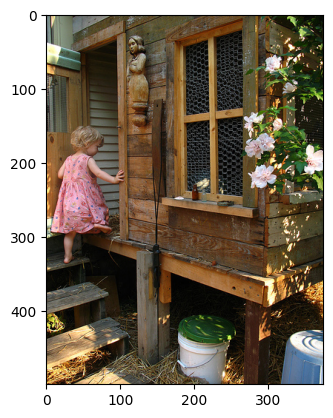

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
img = Image.open("/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg")
plt.imshow(img)

In [17]:
print(mapping['1000268201_693b08cb0e'])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [18]:
import re

def clean(mapping):
    for key, cap in mapping.items():
        for i in range(len(cap)):
            caption = cap[i]
            caption = caption.lower() 
            caption = re.sub(r'[^a-z\s]', '', caption)  
            caption = re.sub(r'\s+', ' ', caption)  
            caption = 'start ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' end'  
            cap[i] = caption 


In [19]:
clean(mapping)

In [20]:
mapping['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [21]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [22]:
len(all_captions)

40455

In [23]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [24]:
vocab_size

8574

In [25]:
max_len=max(len(caption.split())for caption in all_captions)

In [26]:
max_len

31

In [27]:
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.8)
train=image_ids[:split]
test=image_ids[split:]

In [28]:
print(len(test))

1619


In [29]:
def data_gen(data_keys, mapping, features, tokenizer, max_len, vocab_size, batch_size):
    x1, x2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_len, padding='post')[0] 
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                x1, x2, y = np.array(x1), np.array(x2), np.array(y)
                yield (x1, x2), y
                x1, x2, y = list(), list(), list()
                n = 0

In [30]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
fe2 = Dropout(0.4)(fe2)
fe3 = Dense(256, activation='relu')(fe2)

inputs2 = Input(shape=(max_len,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = LSTM(256, return_sequences=True)(se1) 
se3 = LSTM(256)(se2)

decoder1 = add([fe3, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 31)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      1,049,088 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 31, 256)        │      2,194,944 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 31)             │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 31, 256)        │        525,312 │ embedding[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        525,312 │ lstm[0][0],            │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense_1[0][0],         │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 8574)           │      2,203,518 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,695,294 (25.54 MB)

 Trainable params: 6,695,294 (25.54 MB)

 Non-trainable params: 0 (0.00 B)

None


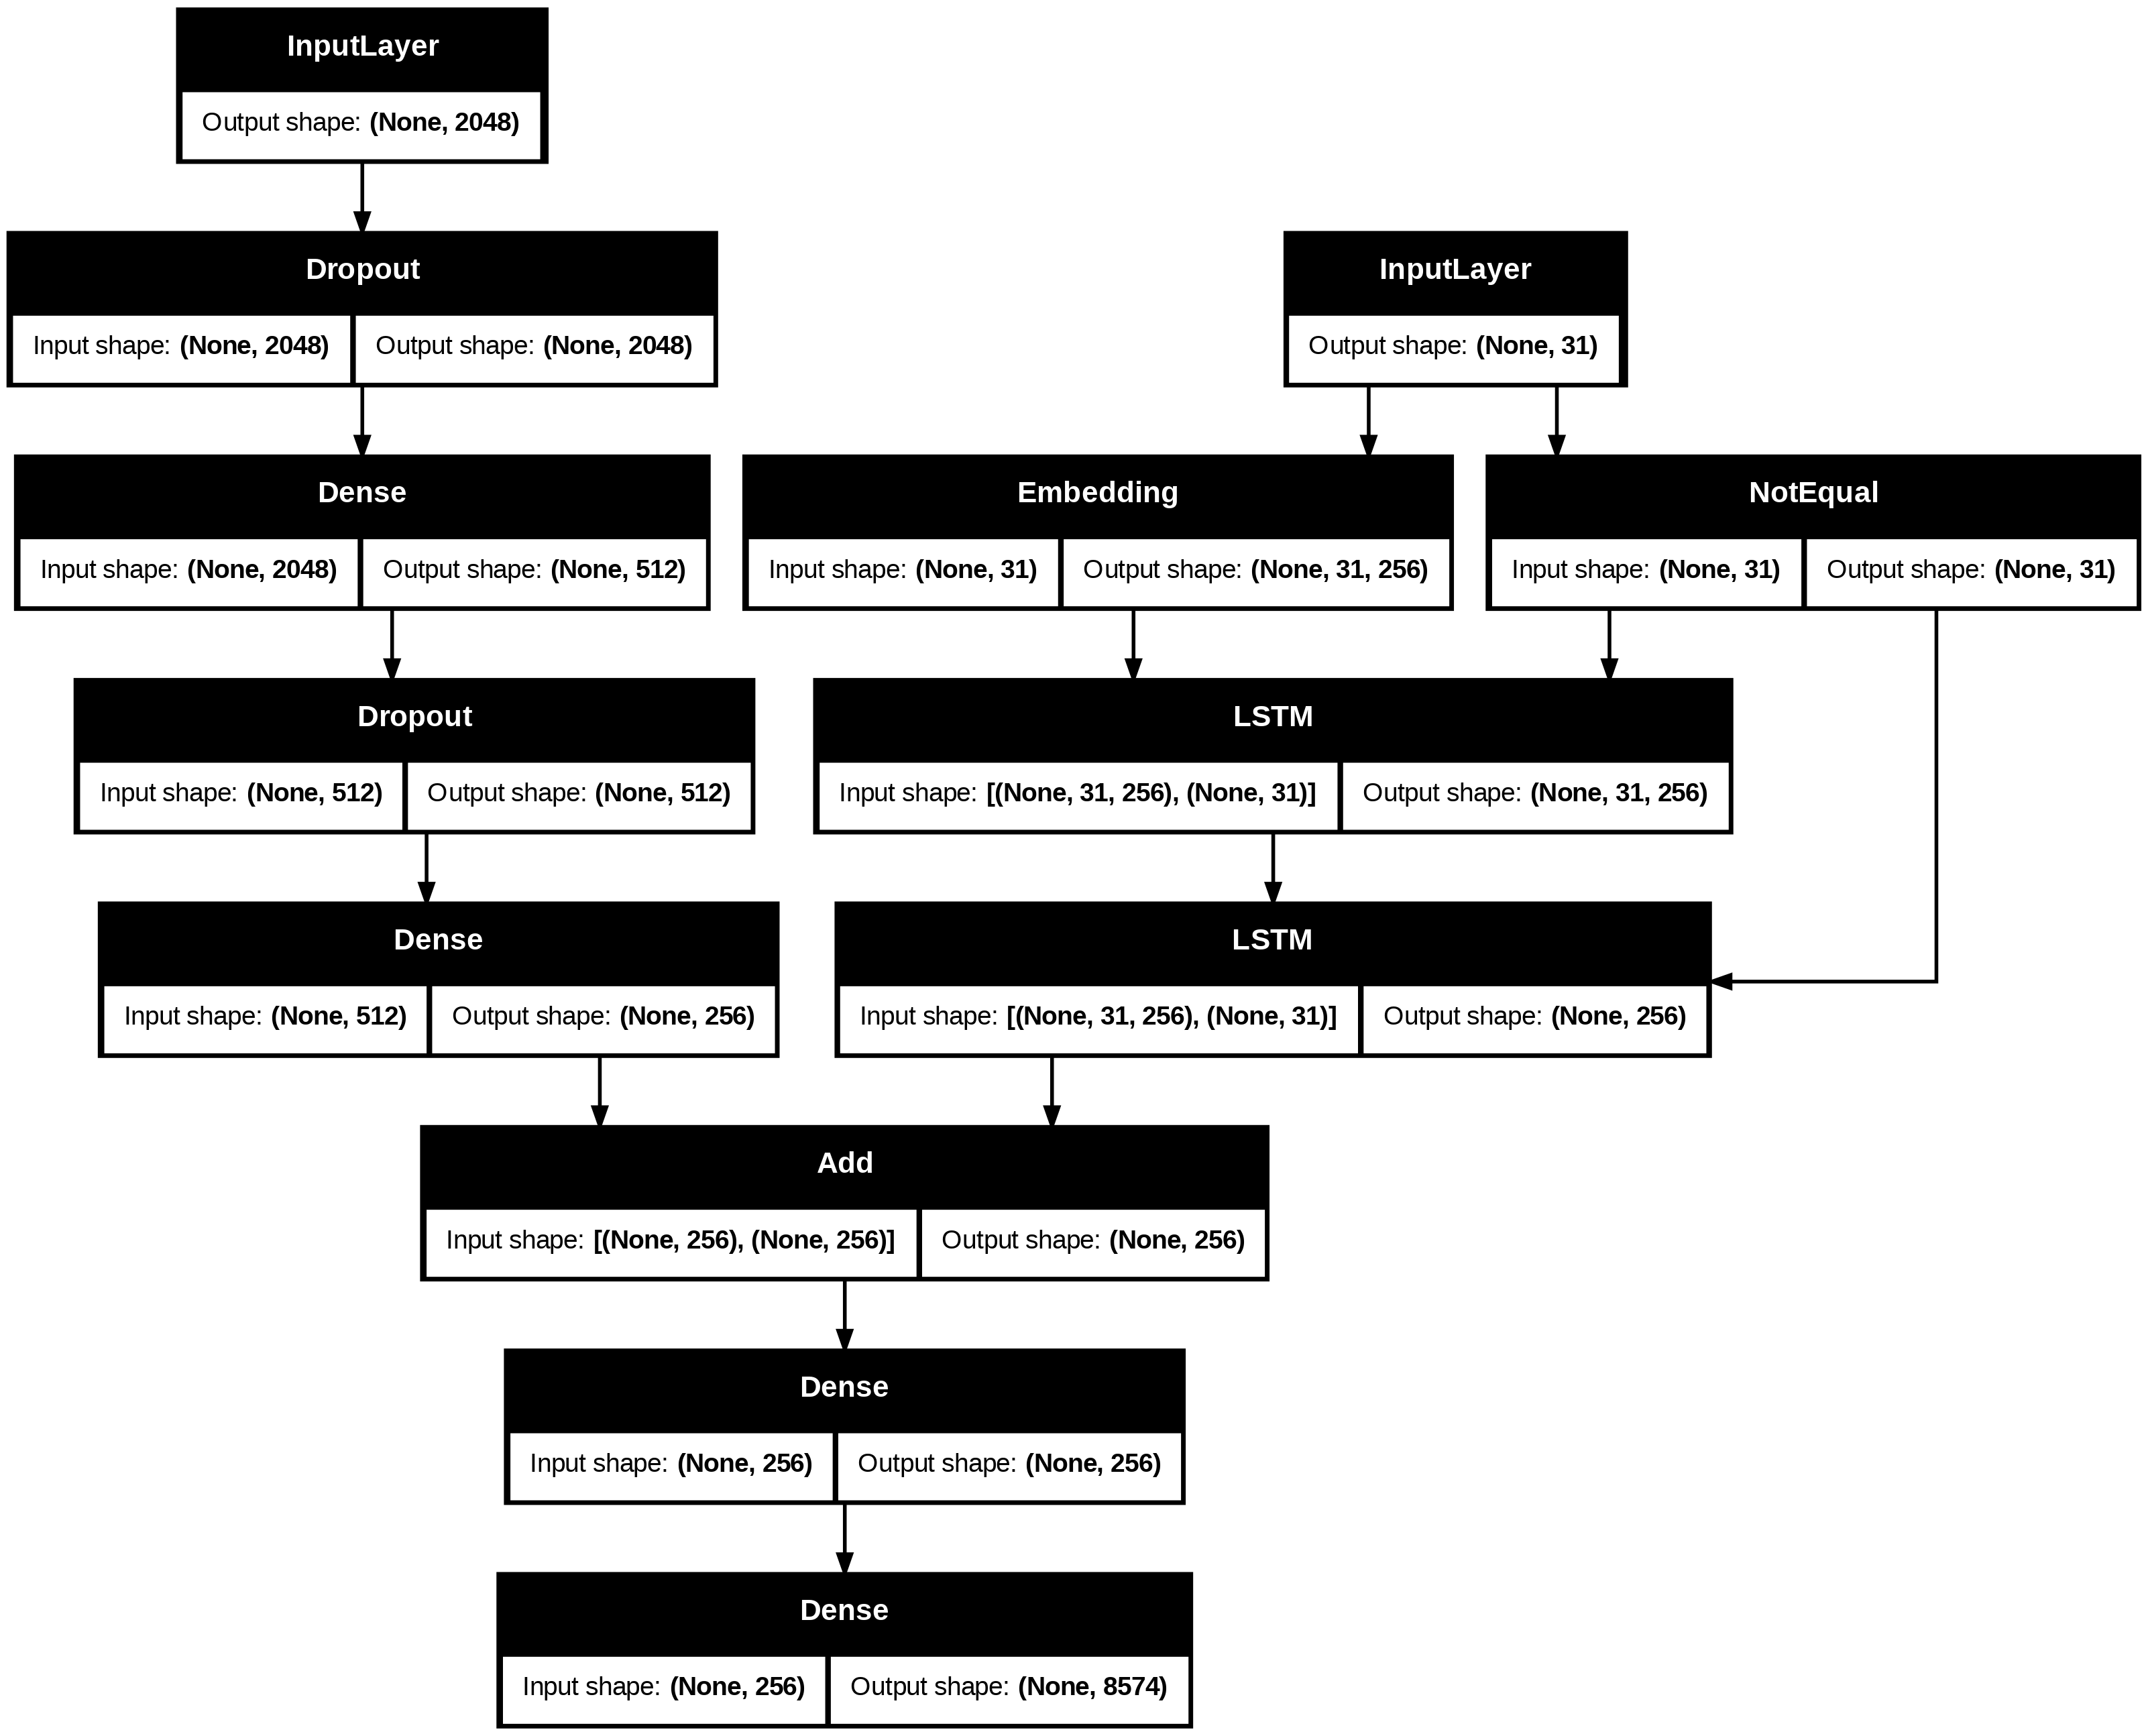

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [32]:
epochs = 25
batch_size = 64
steps = len(train) // batch_size

generator = lambda: data_gen(train, mapping, features, tokenizer, max_len, vocab_size, batch_size)

key = next(iter(features))

dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        (tf.TensorSpec(shape=(None, features[key][0].shape[0]), dtype=tf.float32),
         tf.TensorSpec(shape=(None, max_len), dtype=tf.int32)),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )
)

model.fit(dataset, epochs=epochs, steps_per_epoch=steps, verbose=1)


Epoch 1/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 44s 372ms/step - loss: 6.2951
Epoch 2/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 371ms/step - loss: 4.8390
Epoch 3/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 371ms/step - loss: 4.1117
Epoch 4/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 372ms/step - loss: 3.7851
Epoch 5/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 372ms/step - loss: 3.5742
Epoch 6/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 373ms/step - loss: 3.4152
Epoch 7/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 37s 370ms/step - loss: 3.2946
Epoch 8/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 371ms/step - loss: 3.1856
Epoch 9/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 37s 371ms/step - loss: 3.0928
Epoch 10/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - loss: 3.0077
Epoch 11/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - loss: 2.9305
Epoch 12/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 37s 370ms/step - loss: 2.8633
Epoch 13/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 37s 370ms/step - loss: 2.7998
Epoch 14/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 37s 370ms/step - loss: 2.7393
Epoch 15/25
101

In [33]:
model.save(working+'/image_caption_model.keras')

In [34]:
def index_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [35]:
def predict_caption(model,image,tokenizer,max_len):
    in_text='start'
    for i in range(max_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],max_len,padding='post')
        y_pred=model.predict([image,sequence],verbose=0)
        y_pred=np.argmax(y_pred)
        word=index_to_word(y_pred,tokenizer)
        if word is None:
            break
        in_text+=" " + word
        if word=='end':
            break
    return in_text

In [36]:
from nltk.translate.bleu_score import corpus_bleu

actual,predicted = list() ,list()
for key in tqdm(test):
    captions = mapping[key]
    y_pred=predict_caption(model,features[key],tokenizer,max_len)
    actual_cap=[caption.split() for caption in captions]
    y_pred=y_pred.split()
    actual.append(actual_cap)
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

100%|██████████| 1619/1619 [17:06<00:00,  1.58it/s]


BLEU-1: 0.580242
BLEU-2: 0.354801


Give image name from dataset:  1000268201_693b08cb0e.jpg


----------------------Actual Captions---------------------------------
['start child in pink dress is climbing up set of stairs in an entry way end', 'start girl going into wooden building end', 'start little girl climbing into wooden playhouse end', 'start little girl climbing the stairs to her playhouse end', 'start little girl in pink dress going into wooden cabin end']


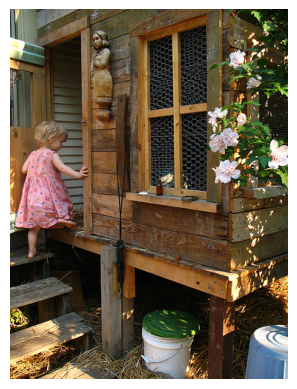

-----------------------------Predicted CAption---------------------------------
start two children are sitting on wooden bench end


In [65]:
image_name=input("Give image name from dataset: ")
image_id=image_name.split(".")[0]
img_path=os.path.join(f"{data_path}/Images/{image_name}")
image=Image.open(img_path)
print("----------------------Actual Captions---------------------------------")
print(mapping[image_id])
ans=predict_caption(model,features[image_id],tokenizer,max_len)
plt.imshow(image)
plt.axis('off')
plt.show()
print("-----------------------------Predicted CAption---------------------------------")
print(ans)

Give path after uploading it:  /kaggle/input/surfing/ljjdb.jpeg


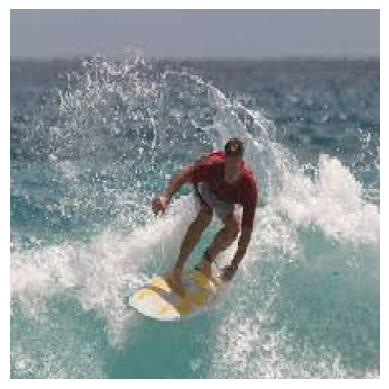

start surfer rides wave end


In [60]:
img_path=input("Give path after uploading it: ")
image = load_img(img_path, target_size=(224, 224))
plt.imshow(image)
plt.axis('off')
plt.show()
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
feature = model_res.predict(image, verbose=0)
caption=predict_caption(model,feature,tokenizer,max_len)

print(caption)
